In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from Model import Model
from config import get_config, get_tokenizer, get_preprocessed_sequence, get_causal_mask, get_tokenized_text, checkpoint#, get_preprocessed_sequence_pd_csv

ImportError: cannot import name 'get_preprocessed_sequence_pd_csv' from 'config' (c:\Users\zac's\PERSONAL\vscode projects\llm\config.py)

loss visualization

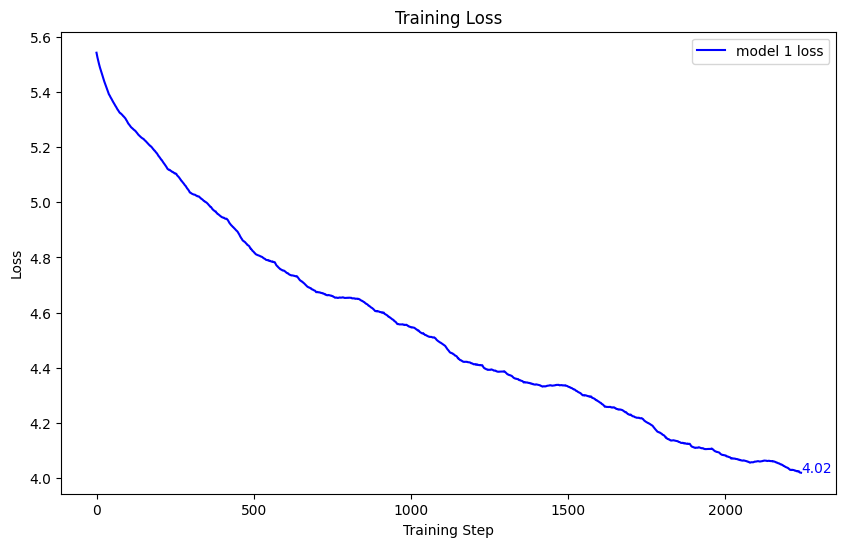

In [4]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
window_size = 1000
plt.figure(figsize=(10, 6))
max_length = len(pd.read_csv('saved/1/losses.csv')['losses'].values.tolist())

losses = pd.read_csv('saved/2/losses.csv')['losses'].values.tolist()[:max_length]
smoothed_losses = moving_average(losses, window_size)
plt.plot(smoothed_losses, label='model 2 loss', color='blue')
plt.annotate(f"{smoothed_losses[-1]:.2f}", xy=(len(smoothed_losses), smoothed_losses[-1]), textcoords="data", color='blue')

plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

model inference

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

config =  get_config()
tokenizer, vocab_size = get_tokenizer()

loaded_model = Model(embed_dim=config["embed_dim"],
              num_blocks=config["num_blocks"], 
              num_heads=config["num_heads"], 
              ff_dim=config["ff_dim"], 
              # dropout_rate=conf["dropout_rate"],
              batch_size=config["batch_size"], 
              vocab_size=vocab_size).to(device)
loaded_model.load_state_dict(torch.load('saved/1/model.pth'))
loaded_model.eval()

# inference should k means sort picking(or something like that, like it should pick based on the tokens confidences as percentages * constant)
tokenized_text = get_tokenized_text(tokenizer, device)
sequence = tokenized_text[random.randint(0, tokenized_text.shape[0]-1)].view(1, -1)
# print(sequence, sequence.shape)

while sequence[-1] != tokenizer("[END]") and sequence.shape[-1] < 100:
    causal_mask = get_causal_mask((sequence.shape[1], sequence.shape[1]), device)
    logits, probs = loaded_model(sequence, key_padding_mask = None, causal_mask = causal_mask) # dont really need causal_mask
    predicted_token = torch.argmax(probs[0][-1], dim=-1).view(1, -1)
    sequence = torch.cat((sequence, predicted_token), dim=-1)
    # print(sequence.shape)
    # print(sequence)
print(''.join(map(str, [tokenizer.decode(token.item()) for token in sequence[0]])))



cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (338027 > 1024). Running this sequence through the model will result in indexing errors








PETRUCHIO:
I am a good, I'll be.

PETRUCHIO:
I'll tell me, I'll be so,
And I'll tell me, I'll be,
And I'll tell me,
And I have you, and I'll tell me,
And I'll tell me,
And I'll tell me,
And I have you, I'll tell me,
And I'll


attention visualization

validation loss